In [96]:
import numpy as np
from constants import *
from scripts.scripts import *
from scripts.gdal_scripts import *
import geopandas as gp

In [97]:
main_name = "only_bm"

In [98]:
df = get_pandas_from_csv(csv_name=main_name,sep=",",index_col=0)

In [99]:
from dataclasses import dataclass
@dataclass
class Bin:
    description: str
    lower_bound: int
    upper_bound: int
    enum: int


In [100]:
BM_BINS = (Bin("First bin", 20, 40, 1), Bin("Second bin", 40,50, 2))

In [101]:
column = "bm_dens"
conditions = []
categories = []

for bin in BM_BINS:
    conditions.append((df[column] >= bin.lower_bound) & (df[column] <= bin.upper_bound))
    categories.append(bin.enum)
df[column+"_s"] = np.select(conditions, categories)

In [7]:
target_column = "bm_dens_s"
df = df[df[target_column] != 0].copy()

In [8]:
df.shape

(32267, 6)

In [42]:
geo_df = dataframe_to_shp(input_df=df)

In [43]:
geo_df = geo_df.reset_index()

In [44]:
geo_df = geo_df.drop(columns=['index','bm_dens','bm_size','bm_dead'])

In [69]:
min_lon, min_lat, max_lon, max_lat = geo_df.total_bounds[0], geo_df.total_bounds[1], geo_df.total_bounds[2], geo_df.total_bounds[3],

In [72]:
import geopy.distance
coords_1 = (min_lat, min_lon) # lat it y, lon is x
coords_2 = (min_lat, max_lon)
width = geopy.distance.geodesic(coords_1, coords_2).m
coords_1 = (min_lat, min_lon) # lat it y, lon is x
coords_2 = (max_lat, min_lon)
height = geopy.distance.geodesic(coords_1, coords_2).m
(width, height)

(7089.832307057682, 5891.213377795518)

In [46]:
tif_name = main_name
geo_df.to_file(filename=SHP_PATH+tif_name+'.shp.zip', driver='ESRI Shapefile', crs='EPSG:4326')

In [111]:
new_main_name = tif_name+"-"+target_column+"-"
new_main_name_full = gdal_run_interpolation(
    input_shp_name="only_bm",
    target_column=target_column,
    output_tif_name=new_main_name,
    algorithm="nearest",
    radius1=0.0005,
    radius2=0.00045,
    width=int(width/5),
    height=int(height/5),
)

Options:  ['-of', 'Gtiff', '-ot', 'Byte', '-outsize', '1417', '1178', '-a', 'nearest:power=1:radius1=0.0005:radius2=0.00045:', '-zfield', 'bm_dens_s']
Running interpolation on: shapefiles/only_bm.shp.zip
Saving to: tif_files/only_bm-bm_dens_s--nearest-0.0005-0.00045.tif


In [109]:
gdal_print_metadata(tif_name=new_main_name_full)

Driver: GTiff/GeoTIFF
Files: tif_files/only_bm-bm_dens_s--nearest-0.0005-0.0005.tif
Size is 708, 589
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (8.943549000000001,56.943967460000003)
Pixel Size = (0.000164530303672,0.000089817877759)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (   8.9435490,  56.9439675) (  8d56'36.78"E, 56d56'38.28"N)
Lower Left  (   8.9435490,  56.9968702) (  8d56'36.78"E, 56d59'48.73"N

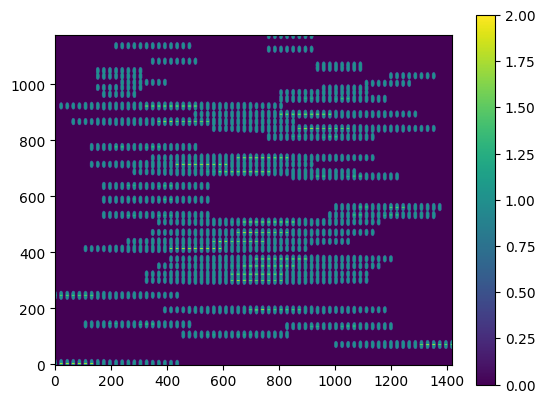

In [112]:
plot_raster(tif_name=new_main_name_full)

In [77]:
print(new_main_name)

only_bm-bm_dens_s-


In [113]:
make_polygons(
    input_tif=new_main_name_full,
    mask='none',
    options=["-mask",new_main_name_full])

Creating output shapefiles/only_bm-bm_dens_s--nearest-0.0005-0.00045.shp.zip of format ESRI Shapefile.


Open shapefile of polygons

In [114]:
polygon_df = gp.read_file(SHP_PATH+new_main_name_full+'.shp.zip')

In [115]:
BM_BINS[0]

Bin(description='First bin', lower_bound=20, upper_bound=40, enum=1)

In [116]:
polygon_dict = {}
for bin in BM_BINS:
    polygon_dict[bin.enum] = polygon_df[polygon_df['DN'] == bin.enum]["geometry"].to_dict()

In [117]:
import simplekml
def make_kml(file_name:str, polygon_dict:dict, colour: str=simplekml.Color.tomato) -> None:
    assert ".kml" not in file_name
    kml = simplekml.Kml()
    multipolodd = kml.newmultigeometry(name="MultiPoly")
    for _, polygon in polygon_dict.items():
        pol = multipolodd.newpolygon(
            name="polygon",
            outerboundaryis=list(polygon.exterior.coords)
        )
        pol.style.polystyle.color = colour
        pol.style.polystyle.outline = 0
    kml.save(file_name+".kml")

In [120]:
make_kml(
    file_name="kml_file_2",
    polygon_dict=polygon_dict[2],
    colour=simplekml.Color.blue,
)

In [2]:
file = gp.read_file(SHP_PATH+tif_name_full+'.shp.zip')

NameError: name 'tif_name_full' is not defined

In [9]:
from osgeo_utils.samples import ogr2ogr
def main():
  ogr2ogr.main(["","-f", "KML", "out75.kml", SHP_PATH+"new75.shp.zip","-simplify", "0.0001"])
main()

In [122]:
kml = gp.read_file("out75.kml")

DriverError: unsupported driver: 'KML'